In [1]:
import pickle

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [2]:
def subset(d, ks):
    """
    Takes a subset of dictionary `d`.
    """
    dn = {k: d[k] for k in ks}
    return dn


def calc_index_lag(a, b):
    """
    Naive lag estimation necessary to shift `a` to align with `b`.
    """
    C = len(a)
    assert len(b) == C
    X = np.correlate(a, b, "full")
    # Offset for symmetric, and then handle off-by-one indexing... I guess?
    lag = X.argmax() - C + 1
    return lag


def rms(x):
    return np.sqrt(np.mean(np.square(x), axis=0))


def metrics(x):
    x_abs = np.abs(x)
    return dict(
        mean_abs=np.mean(x_abs, axis=0).tolist(),
        max_abs=np.max(x_abs, axis=0).tolist(),
        rms=rms(x).tolist(),
    )

In [3]:
ndof = 7
file = "./data/2020-11-02T23_00_27-05_00.pkl"
proc_file = f"{file}.processed.pkl"

In [4]:
has_raw = False

if has_raw:

    with open(file, "rb") as f:
        events = pickle.load(f)

    ts = []
    qa = []
    va = []
    vd = []

    t0_abs_usec = events[0][1].utime

    for status, cmd in events:
        t = (cmd.utime - t0_abs_usec) / 1e6
        ts.append(t)
        qa.append(status.joint_position)
        va.append(status.joint_velocity)
        vd.append(cmd.joint_velocity)

    ts = np.asarray(ts)
    qa = np.asarray(qa)
    va = np.asarray(va)
    vd = np.asarray(vd)

    sub = subset(locals(), ("ts", "qa", "va", "vd", "ndof", "file"))
    with open(proc_file, "wb") as f:
        pickle.dump(sub, f)
    print(proc_file)

else:
    
    with open(proc_file, "rb") as f:
        sub = pickle.load(f)
    
    ts, qa, va, vd = map(sub.get, ("ts", "qa", "va", "vd"))

In [5]:
C = len(ts)
dts = np.diff(ts)

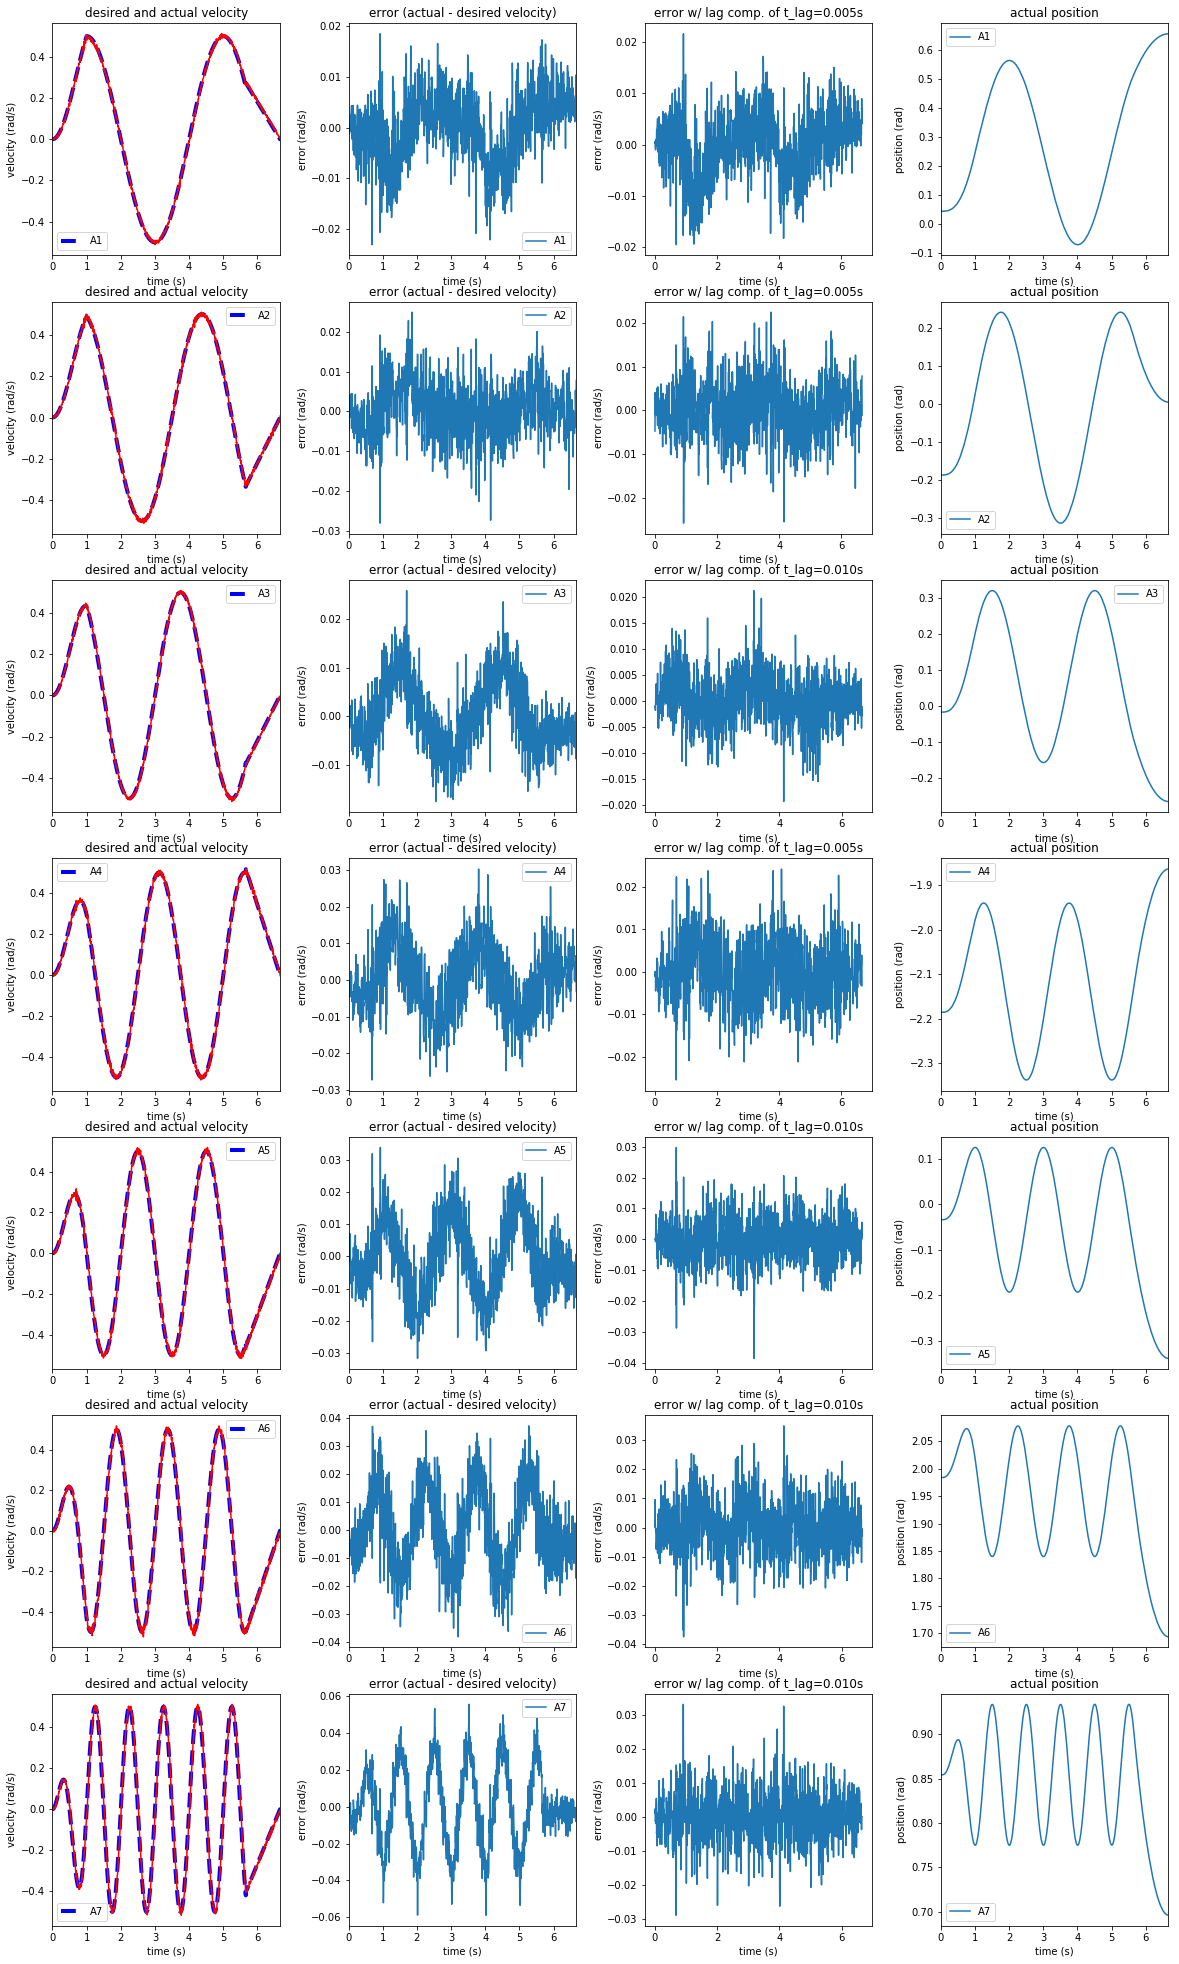

In [6]:
fig, axs = plt.subplots(
    nrows=ndof, ncols=4, squeeze=False, figsize=(20, ndof * 5),
)
plt.subplots_adjust(wspace=0.3)

doc = dict()

for i, ax_col in enumerate(axs):
    sub_both = sub_both = (slice(0, C), i)
    qa_i = qa[sub_both]
    va_i = va[sub_both]
    vd_i = vd[sub_both]
    ts_i = ts

    name = f"A{i+1}"

    def setup():
        plt.xlim(ts[0], ts[-1])
        plt.legend([name])

    plt.sca(ax_col[0])
    plt.plot(ts_i, vd_i, "--", linewidth=4, color="b")
    plt.plot(ts_i, va_i, color="r")
    plt.xlabel("time (s)")
    plt.ylabel("velocity (rad/s)")
    plt.title("desired and actual velocity")
    setup()

    plt.sca(ax_col[1])
    plt.plot(ts_i, va_i - vd_i)
    plt.xlabel("time (s)")
    plt.ylabel(f"error (rad/s)")
    plt.title("error (actual - desired velocity)")
    setup()

    # Dumb consistency check for auto-correlation
    assert calc_index_lag(va_i, va_i) == 0
    assert calc_index_lag(vd_i, vd_i) == 0
    d_to_a = calc_index_lag(va_i, vd_i)
    t_lag = np.mean(dts) * d_to_a
    va_i_lag = va_i[d_to_a:]
    vd_i_lag = vd_i[:-d_to_a]
    ts_i_lag = ts[:-d_to_a]

    plt.sca(ax_col[2])
    plt.plot(ts_i_lag, va_i_lag - vd_i_lag)
    plt.xlabel("time (s)")
    plt.ylabel(f"error (rad/s)")
    plt.title(f"error w/ lag comp. of t_lag={t_lag:0.3f}s")

    plt.sca(ax_col[3])
    plt.plot(ts_i, qa_i)
    plt.xlabel("time (s)")
    plt.ylabel(f"position (rad)")
    plt.title("actual position")
    setup()
    
    doc[name] = dict(
        velocity=dict(
            nominal=metrics(va_i - vd_i),
            lag_comp=metrics(va_i_lag - vd_i_lag),
        ),
    )

plt.savefig(file + ".plot.png")

In [7]:
import yaml


class CustomDumper(yaml.dumper.SafeDumper):
    def _represent_float(self, data):
        value = f"{data:.3g}"
        return self.represent_scalar('tag:yaml.org,2002:float', value)

CustomDumper.add_representer(float, CustomDumper._represent_float)

print(yaml.dump(doc, default_flow_style=False, Dumper=CustomDumper))

A1:
  velocity:
    lag_comp:
      max_abs: 0.0216
      mean_abs: 0.00465
      rms: 0.00597
    nominal:
      max_abs: 0.0231
      mean_abs: 0.00521
      rms: 0.0065
A2:
  velocity:
    lag_comp:
      max_abs: 0.0259
      mean_abs: 0.00482
      rms: 0.00619
    nominal:
      max_abs: 0.0281
      mean_abs: 0.00509
      rms: 0.00653
A3:
  velocity:
    lag_comp:
      max_abs: 0.0212
      mean_abs: 0.00379
      rms: 0.00484
    nominal:
      max_abs: 0.0259
      mean_abs: 0.00571
      rms: 0.00707
A4:
  velocity:
    lag_comp:
      max_abs: 0.0254
      mean_abs: 0.00569
      rms: 0.0072
    nominal:
      max_abs: 0.0303
      mean_abs: 0.0074
      rms: 0.00927
A5:
  velocity:
    lag_comp:
      max_abs: 0.0386
      mean_abs: 0.00547
      rms: 0.007
    nominal:
      max_abs: 0.0338
      mean_abs: 0.00921
      rms: 0.0113
A6:
  velocity:
    lag_comp:
      max_abs: 0.0375
      mean_abs: 0.00703
      rms: 0.0089
    nominal:
      max_abs: 0.0381
      mean_a